In [9]:
import pandas as panda
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Read Data

In [2]:
dataset = panda.read_csv("/content/HateSpeechData.csv")
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


View instances per class

In [3]:
dataset.value_counts(subset='class')

class
1    19190
2     4163
0     1430
dtype: int64

Text(0, 0.5, 'Number of Occurances')

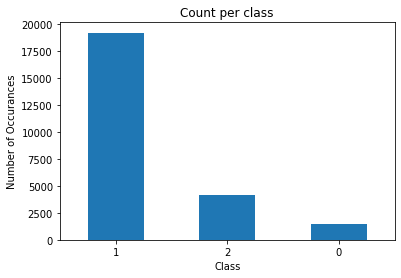

In [4]:
count_classes = dataset.value_counts(dataset['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Count per class")
plt.xlabel("Class")
plt.ylabel("Number of Occurances")

In [5]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

In [6]:
print(tweet.head())

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object


Pre processing tweets

In [7]:
# drop duplicate tweet
tweet.drop_duplicates(inplace = True)


In [10]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

In [11]:
#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

In [12]:

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
print(dataset[["processed_tweets"]].head(10))

                                    processed_tweets
0  woman complain clean hous amp man alway take t...
1  boy dat cold tyga dwn bad cuffin dat hoe st place
2         dawg ever fuck bitch start cri confus shit
3                                   look like tranni
4     shit hear might true might faker bitch told ya
5      shit blow claim faith somebodi still fuck hoe
6              sit hate anoth bitch got much shit go
7            caus tire big bitch come us skinni girl
8               amp might get ya bitch back amp that
9                    hobbi includ fight mariam bitch


Visualization of words

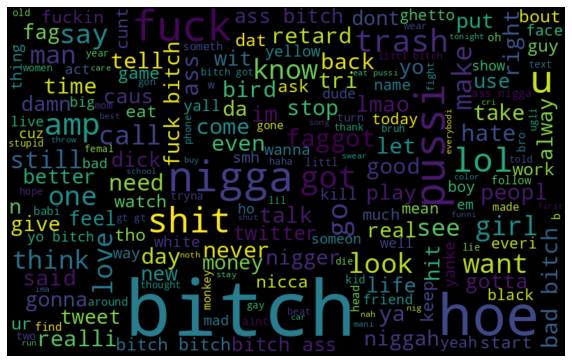

In [13]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

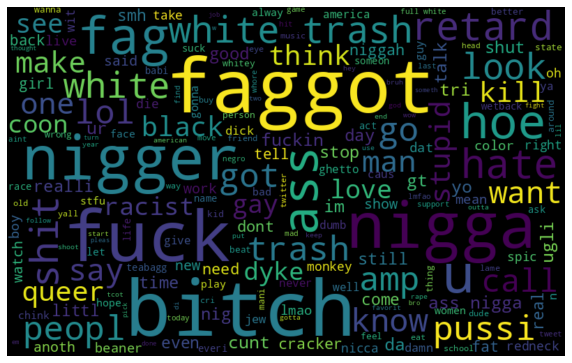

In [14]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

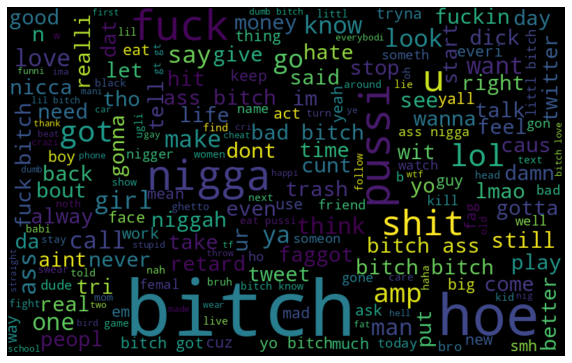

In [15]:

# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Feature extraction using TF-IDF

In [16]:
#TF-IDF Features-F1
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=100000)
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
print(tfidf)

  (0, 5549)	0.4309517500614609
  (0, 5823)	0.21292360474103067
  (0, 5536)	0.2694725323170756
  (0, 103)	0.2848504306418305
  (0, 3639)	0.2500076439754137
  (0, 124)	0.22951771468335722
  (0, 2896)	0.32473278046308335
  (0, 1189)	0.37180372772740344
  (0, 1266)	0.37805333846740247
  (0, 6262)	0.33673876130852654
  (1, 1455)	0.35408569797294004
  (1, 4385)	0.29402989193760287
  (1, 5340)	0.3008029767463628
  (1, 2717)	0.12204320836205955
  (1, 1388)	0.37776257623201304
  (1, 321)	0.20828940991978914
  (1, 5944)	0.35642794983844883
  (1, 1221)	0.3008029767463628
  (1, 1453)	0.47084617485060926
  (1, 892)	0.2397588136195512
  (2, 723)	0.4025857370799935
  (2, 2121)	0.26875711871483904
  (2, 1802)	0.4334907503536408
  (2, 5054)	0.19413584053699529
  (2, 1279)	0.366125652299236
  :	:
  (24780, 960)	0.343011332843257
  (24780, 63)	0.37409643142606824
  (24780, 4095)	0.26604418498734955
  (24780, 1544)	0.2613777761879398
  (24780, 2187)	0.2280990649157048
  (24780, 1713)	0.21384505532921141
 

Logistic regression before optimising

In [17]:

X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=50, test_size=0.2)
model = LogisticRegression()
model.fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
LR_F1=fscore
print('Logistic regression F1:{}'.format(LR_F1))

              precision    recall  f1-score   support

           0       0.65      0.25      0.36       288
           1       0.92      0.97      0.94      3847
           2       0.87      0.85      0.86       822

    accuracy                           0.91      4957
   macro avg       0.81      0.69      0.72      4957
weighted avg       0.90      0.91      0.90      4957

Logistic Regression, Accuracy Score: 0.9065967318942909
Logistic regression F1:0.89587799674375


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


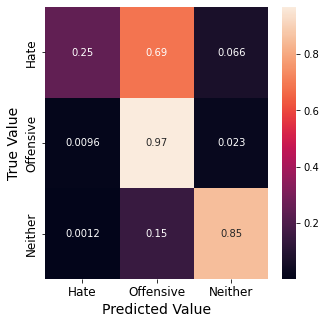

In [18]:
#Confusion Matrix for LR

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#optimizing LR model

# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : [1,2,3],
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 200],
#     'class_weight' : ['balanced'],
#     'multi_class':['auto', 'ovr', 'multinomial']
#     }
# ]
# 
# optimal_params = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# optimal_params.fit(X_train_tfidf,y_train)
# print(optimal_params.best_params_)

Logistic regression after optimisation

In [19]:
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=50, test_size=0.2)
model = LogisticRegression(penalty='l2',C=1,solver='liblinear',max_iter=100,multi_class='auto',class_weight='balanced')
model.fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
LR_F1=fscore
print('Logistic regression F1:{}'.format(LR_F1))

              precision    recall  f1-score   support

           0       0.46      0.53      0.49       288
           1       0.96      0.92      0.94      3847
           2       0.83      0.94      0.88       822

    accuracy                           0.90      4957
   macro avg       0.75      0.80      0.77      4957
weighted avg       0.91      0.90      0.90      4957

Logistic Regression, Accuracy Score: 0.9013516239661086
Logistic regression F1:0.9040734490245682


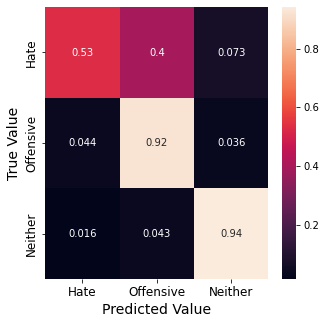

In [20]:
#Confusion Matrix for LR after optimisation
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

Naive bayes

In [21]:

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=10, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)

report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
NB_F1=fscore
print('Naive Bayes F1:{}'.format(NB_F1))

              precision    recall  f1-score   support

           0       0.10      0.36      0.15       285
           1       0.90      0.69      0.78      3815
           2       0.56      0.62      0.59       857

    accuracy                           0.66      4957
   macro avg       0.52      0.56      0.51      4957
weighted avg       0.79      0.66      0.71      4957

Naive Bayes, Accuracy Score: 0.6582610449868872
Naive Bayes F1:0.709870945000923


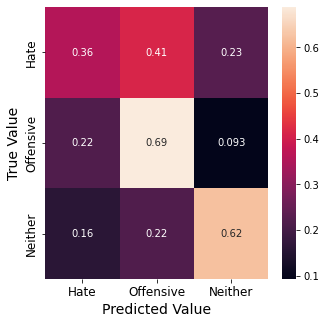

In [22]:
#Confusion Matrix for NB
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

Support vector machine

In [23]:
support =LinearSVC(random_state=50)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
SVM_F1=fscore
print('SVM F1:{}'.format(SVM_F1))

              precision    recall  f1-score   support

           0       0.59      0.27      0.37       285
           1       0.93      0.96      0.94      3815
           2       0.85      0.87      0.86       857

    accuracy                           0.90      4957
   macro avg       0.79      0.70      0.72      4957
weighted avg       0.89      0.90      0.90      4957

SVM, Accuracy Score: 0.9041759128505145
SVM F1:0.8955420196113896


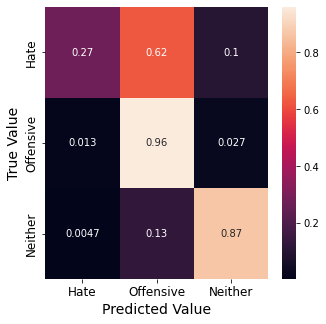

In [24]:
#Confusion Matrix for SVM
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#optimizing the SVM
# param_grid = [
#     {'penalty':['l1', 'l2'],
#     'loss': ['hinge','squared_hinge'],
#     'max_iter':[100, 200] }
# ]


# optimal_params= GridSearchCV(
#     support,
#     param_grid,
#     cv = 5,
#     scoring = 'accuracy',
#     verbose = 2
# )

# optimal_params.fit(X_train_tfidf,y_train)
# print(optimal_params.best_params_)

SVM after optimisation

In [25]:
support =LinearSVC(loss='hinge',max_iter=100,penalty='l2',random_state=50)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

precision,recall,fscore,support=score(y_test,y_preds,average='weighted')
SVM_F1=fscore
print('SVM F1:{}'.format(SVM_F1))

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.64      0.20      0.30       285
           1       0.93      0.96      0.95      3815
           2       0.85      0.90      0.87       857

    accuracy                           0.91      4957
   macro avg       0.81      0.69      0.71      4957
weighted avg       0.90      0.91      0.90      4957

SVM, Accuracy Score: 0.9092192858583821
SVM F1:0.8967242151872498


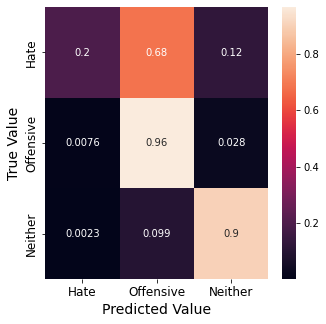

In [26]:
#Confusion Matrix for SVM after optimisation 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True)
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

Comparison betweet accuracies for all three models

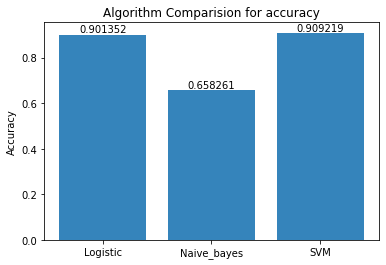

In [27]:

objects = ('Logistic', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc2,acc3]
bars=plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.bar_label(bars)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for accuracy')
plt.show()


Comparison betweet F1 score for all three models

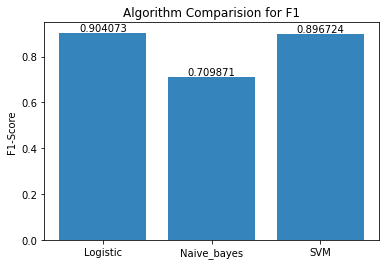

In [ ]:

objects = ('Logistic', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [LR_F1,NB_F1,SVM_F1]
bars=plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.bar_label(bars)
plt.xticks(y_pos, objects)
plt.ylabel('F1-Score')
plt.title('Algorithm Comparision for F1')
plt.show()